<a href="https://colab.research.google.com/github/APWright/6242Project/blob/master/Analysis/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
import os
import networkx

In [2]:
from getpass import getpass
username = input('Github Username: ')
password = getpass('Github Password: ')
clone_repo = "git clone https://{}:{}@github.com/APWright/6242Project.git".format(username,password)
os.system(clone_repo)
password = ""
%cd 6242Project/Analysis

Github Username: apwright
Github Password: ··········
/content/6242Project/Analysis


In [3]:
codes = pd.read_csv("../Data/RawData/iso_codes_numeric_abbrevs.csv")

democracy_score = pd.read_csv("../Data/CleanData/Democracy-Autocracy-score-csv.csv")
gdp_score = pd.read_csv("../Data/CleanData/GDP_per_cap_clean.csv")
avg_temp = pd.read_csv("../Data/CleanData/average_temp_country.csv")
avg_school_years = pd.read_csv("../Data/CleanData/avg_school_years.csv")
birth_rates = pd.read_csv("../Data/CleanData/birth_rates.csv")
land_locked = pd.read_csv("../Data/CleanData/country_land_locked_clean.csv")
water_scaricity = pd.read_csv("../Data/CleanData/country_water_scarcity_clean.csv")
natural_disasters = pd.read_csv("../Data/CleanData/natural_disaster_clean.csv")

trade = pd.read_csv("../Data/CleanData/trade_depencies_clean.csv")
edge_features = trade.dropna()

migration = pd.read_csv("../Data/CleanData/migration_flows_v2.csv")

data_index = ['src_num', 'src_abb', 'tgt_num', 'tgt_abb', 'year']

node_features = pd.merge(democracy_score,gdp_score, on=data_index)
node_features = pd.merge(node_features,avg_temp, on=data_index).drop(['Unnamed: 0',"Name"],axis=1).rename(columns={'avg':'avg_temp'})
node_features = pd.merge(node_features,avg_school_years, on=data_index)
node_features = pd.merge(node_features,birth_rates, on=data_index)
node_features = pd.merge(node_features,land_locked, on=data_index).drop(['Unnamed: 0',"Country"],axis=1)
water_scaricity['Risk_Level'] = water_scaricity['Risk_Level'].map(lambda rl: {'Extremely-high':5, 'High':4, 'Low':1, 'Low-medium':2, 'Medium-high':3}[rl])
node_features = pd.merge(node_features,water_scaricity, on=data_index).drop(['Unnamed: 0','Rank ',"Country",'Extremely-high', 'High', 'Low', 'Low-medium', 'Medium-high'],axis=1).rename(columns={'Risk_Level':'water_risk'})
node_features = pd.merge(node_features,natural_disasters, on=data_index).drop(['Unnamed: 0',"Country","Prone_Disasters"],axis=1)
node_features = node_features.drop(['src_abb', 'tgt_num', 'tgt_abb'],axis=1)
node_features = node_features.dropna()
node_features

,src_num,year,democ,autoc,GDP_per_cap,avg_temp,years_in_school,birth_rateper1000,LandLocked,water_risk,snow,tsunami,tornado,avalanche,fire,severe_storms,mudslide,icestorms,tropical_storms
1,124,1961,10,0,2274.423273,4.312072,8.112,26.00,0,1,1,0,0,0,0,1,0,0,0
2,124,1962,10,0,2303.002686,4.085360,8.164,25.20,0,1,1,0,0,0,0,1,0,0,0
3,124,1963,10,0,2410.522624,4.252280,8.216,24.60,0,1,1,0,0,0,0,1,0,0,0
4,124,1964,10,0,2593.875448,4.044781,8.268,23.40,0,1,1,0,0,0,0,1,0,0,0
5,124,1965,10,0,2812.391734,3.962283,8.320,21.30,0,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,554,2017,10,0,42260.125180,12.967560,12.500,12.43,0,1,0,0,0,1,0,1,0,0,0
15732,554,2017,10,0,42260.125180,12.967560,12.500,12.43,0,1,0,0,0,1,0,1,0,0,0
15733,554,2017,10,0,42260.125180,12.967560,12.440,12.43,0,1,0,0,0,1,0,1,0,0,0
15734,554,2017,10,0,42260.125180,12.967560,12.320,12.43,0,1,0,0,0,1,0,1,0,0,0


In [4]:
(min(np.unique(migration['year'])),max(np.unique(migration['year']))) 

(1960, 2010)

In [0]:
start_year = 1960
end_year = 2015

In [0]:
node_features = node_features[node_features['year'] >= start_year]
node_features = node_features[node_features['year'] <= end_year]
edge_features = edge_features[edge_features['year'] >= start_year]
edge_features = edge_features[edge_features['year'] <= end_year]

In [7]:
(min(np.unique(node_features['year'])),max(np.unique(node_features['year'])))

(1960, 2015)

In [14]:
target_df = migration.drop(['stock',	'demo',	'sex','interval'],axis=1)
target_df = target_df.groupby(data_index,as_index=False).mean()
target_df

,src_num,src_abb,tgt_num,tgt_abb,year,flow
0,4,AFG,4,AFG,1960,0.0
1,4,AFG,4,AFG,1965,0.0
2,4,AFG,4,AFG,1970,0.0
3,4,AFG,4,AFG,1975,0.0
4,4,AFG,4,AFG,1980,0.0
...,...,...,...,...,...,...
413604,894,ZMB,894,ZMB,1990,0.0
413605,894,ZMB,894,ZMB,1995,0.0
413606,894,ZMB,894,ZMB,2000,0.0
413607,894,ZMB,894,ZMB,2005,0.0


In [15]:
regression_df = pd.merge(edge_features,node_features,on=['src_num','year'])
regression_df = pd.merge(regression_df,node_features,left_on=['tgt_num','year'],right_on=['src_num','year'],suffixes=('_src','_tgt'))
regression_df = regression_df.drop(['src_num_tgt'],axis=1)
regression_df = regression_df.rename(columns={'src_num_src':'src_num'})
regression_df

,src_abb,src_num,tgt_abb,tgt_num,year,trade_dependence,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,AGO,24.0,ARG,32,2015.0,0.000510,2,4,4166.979684,22.792083,5.000,42.520,0,2,0,0,0,0,0,1,0,0,0,9,0,13789.060420,16.846381,9.800,17.548,0,2,0,0,0,0,0,1,0,0,0
1,AGO,24.0,ARG,32,2015.0,0.000510,2,4,4166.979684,22.792083,5.000,42.520,0,2,0,0,0,0,0,1,0,0,0,9,0,13789.060420,16.846381,9.800,17.548,0,2,0,0,0,0,0,1,0,0,0
2,AGO,24.0,ARG,32,2015.0,0.000510,2,4,4166.979684,22.792083,5.000,42.520,0,2,0,0,0,0,0,1,0,0,0,9,0,13789.060420,16.846381,9.800,17.548,0,2,0,0,0,0,0,1,0,0,0
3,AGO,24.0,ARG,32,2015.0,0.000510,2,4,4166.979684,22.792083,5.000,42.520,0,2,0,0,0,0,0,1,0,0,0,9,0,13789.060420,16.846381,9.800,17.548,0,2,0,0,0,0,0,1,0,0,0
4,AGO,24.0,ARG,32,2015.0,0.000510,2,4,4166.979684,22.792083,5.000,42.520,0,2,0,0,0,0,0,1,0,0,0,9,0,13789.060420,16.846381,9.800,17.548,0,2,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4112112,BFA,854.0,ROU,642,2002.0,0.000111,2,2,260.763541,28.834697,1.240,45.778,1,4,0,0,0,0,0,0,0,0,0,8,0,2119.882673,10.142833,9.680,9.700,0,2,0,0,0,0,0,1,0,0,0
4112113,BFA,854.0,ROU,642,2002.0,0.000111,2,2,260.763541,28.834697,1.240,45.778,1,4,0,0,0,0,0,0,0,0,0,8,0,2119.882673,10.142833,9.820,9.700,0,2,0,0,0,0,0,1,0,0,0
4112114,BFA,854.0,ROU,642,2002.0,0.000111,2,2,260.763541,28.834697,1.240,45.778,1,4,0,0,0,0,0,0,0,0,0,8,0,2119.882673,10.142833,9.860,9.700,0,2,0,0,0,0,0,1,0,0,0
4112115,BFA,854.0,ROU,642,2002.0,0.000111,2,2,260.763541,28.834697,1.240,45.778,1,4,0,0,0,0,0,0,0,0,0,8,0,2119.882673,10.142833,9.780,9.700,0,2,0,0,0,0,0,1,0,0,0


In [16]:
total_regression_df = pd.merge(target_df,regression_df,on=data_index)
total_regression_df

,src_num,src_abb,tgt_num,tgt_abb,year,flow,trade_dependence,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,4,AFG,40,AUT,1960,35.333333,0.001302,0,10,59.773194,14.091667,0.22,51.279,1,4,0,0,0,0,0,0,0,0,0,10,0,935.460427,6.900401,5.94,17.900,1,1,0,0,0,1,0,0,0,0,0
1,4,AFG,40,AUT,1965,32.000000,0.000894,0,7,101.108305,17.684167,0.29,51.631,1,4,0,0,0,0,0,0,0,0,0,10,0,1374.532140,6.163750,6.93,17.900,1,1,0,0,0,1,0,0,0,0,0
2,4,AFG,40,AUT,1970,3.000000,0.000114,0,7,156.518939,17.862083,0.35,51.502,1,4,0,0,0,0,0,0,0,0,0,10,0,2058.769079,6.524879,7.63,15.000,1,1,0,0,0,1,0,0,0,0,0
3,4,AFG,40,AUT,1975,358.333333,0.000972,0,7,186.510897,17.111667,0.62,50.930,1,4,0,0,0,0,0,0,0,0,0,10,0,5285.620724,7.280014,7.98,12.400,1,1,0,0,0,1,0,0,0,0,0
4,4,AFG,208,DNK,1965,0.333333,0.000497,0,7,101.108305,17.684167,0.29,51.631,1,4,0,0,0,0,0,0,0,0,0,10,0,2243.931595,7.018250,5.01,18.000,0,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702917,894,ZMB,818,EGY,2010,3.000000,0.013428,7,0,1489.459070,23.041111,6.40,41.194,1,1,0,0,0,0,0,1,0,0,1,1,4,2644.817039,24.050789,6.50,27.266,0,4,0,0,0,0,0,1,0,0,0
702918,894,ZMB,818,EGY,2010,3.000000,0.013428,7,0,1489.459070,23.041111,6.40,41.194,1,1,0,0,0,0,0,1,0,0,1,1,4,2644.817039,24.050789,6.42,27.266,0,4,0,0,0,0,0,1,0,0,0
702919,894,ZMB,818,EGY,2010,3.000000,0.013428,7,0,1489.459070,23.041111,6.40,41.194,1,1,0,0,0,0,0,1,0,0,1,1,4,2644.817039,24.050789,6.28,27.266,0,4,0,0,0,0,0,1,0,0,0
702920,894,ZMB,818,EGY,2010,3.000000,0.013428,7,0,1489.459070,23.041111,6.40,41.194,1,1,0,0,0,0,0,1,0,0,1,1,4,2644.817039,24.050789,6.12,27.266,0,4,0,0,0,0,0,1,0,0,0


In [0]:
target = total_regression_df['flow']
normalizer = StandardScaler()
input = normalizer.fit_transform(total_regression_df[total_regression_df.columns[6:]].values)
model = linear_model.LinearRegression().fit(input,target)

In [0]:
coefs = model.coef_

<BarContainer object of 35 artists>

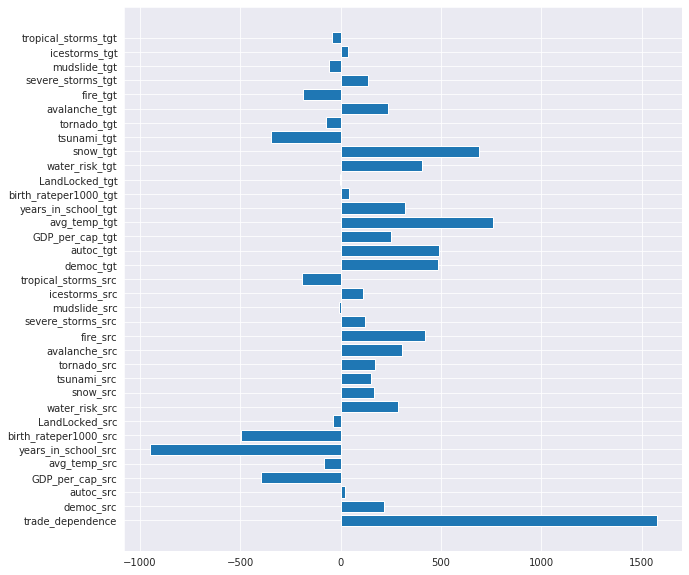

In [32]:
plt.figure(figsize=(10,10))
plt.barh(range(len(coefs)),coefs,tick_label=total_regression_df.columns[6:])